In [7]:
%matplotlib inline
import glob
import pandas as pd
from pyearth import Earth
from datacleaner import autoclean
import matplotlib.pyplot as plt
import numpy as np

In [4]:
filenames = glob.glob('/mnt/disk1/uci/**/*.data')

In [5]:
params_def =dict(
    max_terms=("integer", [1, 100], 10), 
    max_degree=("integer", [1, 30], 5), 
    allow_missing=("categorical", (False,), False), 
    penalty=("real", [0, 20], 3), 
    endspan_alpha=("real", [0, 1], 0.05),
    #endspan=("integer", [1, 100], -1),
    minspan_alpha=("real", [0, 1], 0.05),
    #minspan=("integer", [1, 100], -1),
    thresh=("real", [0, 1], 0.001),
    check_every=("integer", [1, 100], 1),
    allow_linear=("categorical", (True, False), True), 
    smooth=("categorical", (True, False), True), 
    enable_pruning=("categorical", (True, False), True)
)

In [6]:
datasets = {}
for filename in filenames:
    try:
        data = pd.read_csv(filename)
        data = autoclean(data)
    except Exception:
        continue
    else:
        data = data.values
        X, y = data[:, 0:-1], data[:, -1]
        if X.shape[1] > 0:
            datasets[filename] = X, y

In [ ]:
import pysmac
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression

all_params = []
all_scores = []

opt = pysmac.SMAC_optimizer(debug=0, working_directory='/tmp/pysmac_test/', persistent_files=True)

def fit_model(**params):
    #np.random.seed(42)
    score_sum = 0
    score_dataset = []
    for X, y in datasets.values():
        test_size = 0.2
        if X.shape[0] >= 1000:
            test_size = 0.2
        if X.shape[0] >= 500 and X.shape[0] <= 800:
            test_size = 0.3
        if X.shape[0] >= 100 and X.shape[0] < 500:
            test_size = 0.35
        if X.shape[0] < 100:
            test_size = 0.5
        Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_size)
        #print(Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape)
        model = Earth(**params)
        model.fit(Xtrain, ytrain)
        baseline_model = LinearRegression()
        baseline_model.fit(Xtrain, ytrain)
        
        Xs, ys = Xtrain, ytrain
        score = ((model.predict(Xs) - ys)**2).mean()
        score_baseline = ((baseline_model.predict(Xs) - ys)**2).mean()
        score_normalized = score / max(score, score_baseline)
        score_sum += score_normalized
        score_dataset.append(score_normalized)
    print(params)
    print(score_sum, score_dataset)
    all_params.append(params)
    all_scores.append(score_sum)
    return score_sum

np.random.seed(42)
for i in range(1000):
    p = dict(
        max_terms=np.random.randint(1, 100),
        max_degree=np.random.randint(1, 30),
        allow_missing=False, 
        penalty=np.random.uniform(0, 20) ,
        endspan_alpha=np.random.uniform(0, 1),
        minspan_alpha=np.random.uniform(0, 1),
        thresh=np.random.uniform(0, 1),
        check_every=np.random.randint(1, 100),
        allow_linear=np.random.choice((True, False)),
        smooth=np.random.choice((True, False)) ,
        enable_pruning=np.random.choice((True, False)))
    print(p)
    try:
        fit_model(**p)
    except Exception as err:
        print(err)

{'minspan_alpha': 0.596850157946487, 'endspan_alpha': 0.7796910002727693, 'check_every': 87, 'max_terms': 52, 'smooth': True, 'allow_missing': False, 'penalty': 3.668695797323276, 'enable_pruning': False, 'thresh': 0.44583275285359114, 'max_degree': 29, 'allow_linear': True}
{'penalty': 3.668695797323276, 'max_terms': 52, 'check_every': 87, 'endspan_alpha': 0.7796910002727693, 'smooth': True, 'allow_missing': False, 'minspan_alpha': 0.596850157946487, 'enable_pruning': False, 'thresh': 0.44583275285359114, 'max_degree': 29, 'allow_linear': True}
(nan, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, nan, 1.0, 1.0, 0.9442806755591836, 1.0, 0.99999999999999989, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.76272240897835131, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.73704077076688612, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96086281263548345, 1.0, 1.0, 1.0, 1.0, 0.95558363321892259, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.93642289235952358, 1.0, 1.0, 

## pysmac

In [ ]:
opt.minimize(fit_model, 500, params)

In [40]:
import pandas as pd
import json
import re
d = open('/tmp/pysmac_test/out/scenario/live-rundata-0.json').read()
all_params_smac = re.findall(r'"pc-settings" : \{(.*?)\}', d, flags=re.DOTALL)
all_scores_smac = re.findall(r'"r-quality" : (.*?),', d)
all_scores_smac = map(float, all_scores_smac)

for i, param in enumerate(all_params_smac):
    param = "{" + param + "}"
    d = json.loads(param)
    all_params_smac[i] = d
all_scores_smac = np.array(all_scores_smac)

## Plots and visualisations

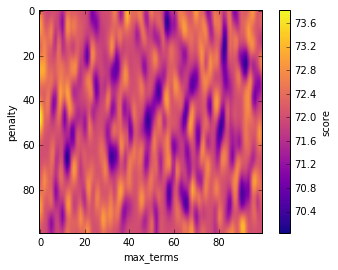

In [53]:
all_scores = np.array(all_scores)
F = ~np.isnan(all_scores)
all_scores_filtered = all_scores[F]
#all_params = [p for i, p in enumerate(all_params) if F[i]]
all_scores_smac = np.array(all_scores_smac)

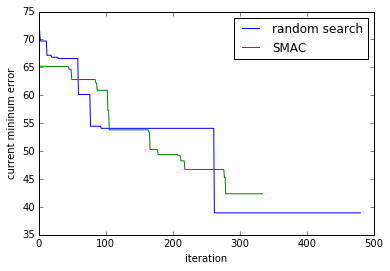

In [52]:
plt.plot(np.minimum.accumulate(all_scores_filtered), label='random search')
plt.plot(np.minimum.accumulate(all_scores_smac), label='SMAC')
plt.xlabel('iteration')
plt.ylabel('current mininum error')
plt.legend()

In [ ]:
fit_model(**all_params[all_scores_filtered.argmin()])

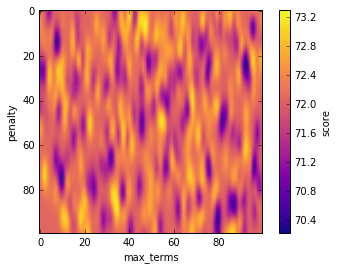

In [57]:
from sklearn.svm import SVR

k = params_def.keys()

v1 = 'max_terms'
v2 = 'penalty'

xx = []
yy = []
for score, param in zip(all_scores, all_params):
    if score > 100:
        continue
    xx.append((param[v1], param[v2]))
    yy.append(score)

xx = np.array(xx, dtype='float32')
yy = np.array(yy, dtype='float32')

model = SVR()
model.fit(xx, yy)
w,h  = 100, 100
xx1, xx2 = np.meshgrid(
    np.linspace(xx[:, 0].min(), xx[:, 0].max(), w),
    np.linspace(xx[:, 1].min(), xx[:, 1].max(), h)
)

xx1 = xx1.flatten()
xx2 = xx2.flatten()
xxs = np.vstack((xx1, xx2)).T
yys = model.predict(xxs)

yys = yys.reshape((w, h))
plt.xlabel(v1)
plt.ylabel(v2)
plt.imshow(yys, cmap='plasma')
plt.colorbar(label='score')
#cm = plt.cm.get_cmap('viridis')
#sc = plt.scatter(xxs[:, 0], xxs[:, 1], cmap=cm, c=yys, s=100, marker='s')
#plt.colorbar(sc)

In [3]:
from sklearn.svm import SVR

def smooth_image(x, y, z, w=100, h=100, model=SVR()):
    model.fit(xx, yy)
    x, y = np.meshgrid(
        np.linspace(x.min(), x.min(), w),
        np.linspace(y.min(), y.max(), h)
    )
    x = x.flatten()
    y = y.flatten()
    xs = np.vstack((x, y)).T
    ys = model.predict(xs)
    ys = ys.reshape((w, h))
    return ys